```
LSTM vs Transformer vs LLaMA vs Diff
```
- 파라미터 수 1.8만 정도의 작은 모델 & with GQA
- 작은 배치 사이즈

In [1]:
## Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 32
HIDDEN_DIM = EMBEDDING_DIM

BATCH_SIZE = 512
EPOCHS = 30
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 64])
Target shape: torch.Size([512, 64])
Sample 1: ------------------------------
Input sequence :  his wisdom hastes our marriage,To stop the inundation of her t
Target sequence: his wisdom hastes our marriage,To stop the inundation of her te

Sample 2: ------------------------------
Input sequence :  us King of England.You are the fount that makes small brooks t
Target sequence: us King of England.You are the fount that makes small brooks to

Sample 3: ------------------------------
Input sequence : an.KING RICHARD II:We did observe. Cousin Aumerle,How far br
Target sequence: n.KING RICHARD II:We did observe. Cousin Aumerle,How far bro



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def ___generate(model, char_to_idx, idx_to_char, start_char, max_length, device):
    model.eval()
    hidden = None
    current_char = start_char
    generated_text = current_char

    for _ in range(max_length):
        x = torch.tensor([[char_to_idx[current_char]]]).to(device)
        output, hidden = model(x, hidden)
        probs = torch.softmax(output[0, -1], dim=0)
        next_char_idx = torch.multinomial(probs, 1).item()
        current_char = idx_to_char[next_char_idx]
        generated_text += current_char

    return generated_text


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [14]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [15]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [16]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [17]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [18]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Use multiple GRU layers with dropout for increased capacity.
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        # Additional fully connected layers to further increase parameters.
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        # Layer normalization after GRU output.
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        # Embedding lookup
        embed = self.embedding(x)
        # GRU forward pass
        output, hidden = self.gru(embed, hidden)
        # Apply dropout and normalization
        output = self.dropout(output)
        output = self.layer_norm(output)
        # Additional FC layer with non-linearity, then final output layer.
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden


In [20]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE)

In [21]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 32]             2,080
├─GRU: 1-2                               [512, 64, 32]             12,672
├─Dropout: 1-3                           [512, 64, 32]             --
├─LayerNorm: 1-4                         [512, 64, 32]             64
├─Linear: 1-5                            [512, 64, 32]             1,056
├─Linear: 1-6                            [512, 64, 65]             2,145
Total params: 18,017
Trainable params: 18,017
Non-trainable params: 0
Total mult-adds (M): 417.97
Input size (MB): 0.26
Forward/backward pass size (MB): 50.59
Params size (MB): 0.07
Estimated Total Size (MB): 50.93

In [ ]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)


Epoch 1/30, Train Loss: 2.3033, Val Loss: 2.2790, Epoch Time: 22.06s Average Vram Usage: 26.66MB


Epoch 2/30, Train Loss: 2.1075, Val Loss: 2.0862, Epoch Time: 24.38s Average Vram Usage: 26.66MB


Epoch 3/30, Train Loss: 2.0093, Val Loss: 2.0254, Epoch Time: 23.46s Average Vram Usage: 26.66MB


Epoch 4/30, Train Loss: 1.9659, Val Loss: 1.9908, Epoch Time: 24.33s Average Vram Usage: 26.66MB


In [ ]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morroug
An;
RI the!
Thand Wou brefese wreamt yey my lerut soir be hagpere shit hat, nude saregesrint'ndn,
Smame nose she's mele yout?
And solle be fof he wop slist end it keld atell wage reL and-e, heat!
Frou beang, doeo? honpent wang the cMomak cous it tainris hast corx, bank and the anger the-me, ead the me Bereal;
Qiis's this me synenis. hour urstid:
Gersst ratuat astiet erond ot wean peele'd the hiXI:
Hunth kele ir thousy, pumed comiat wall dertom this whe sy Isis theau ilf the noderinger,
Wadere


In [ ]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [ ]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro

Model Output (logits for next character prediction):
torch.Size([1, 64, 65])
tensor([ 0.8331, -1.4610, -1.5173, -1.9002, -1.7645, -1.0705, -3.3527, -2.0034,
        -1.3078, -2.3887], device='cuda:0')

Predicted next character:
u


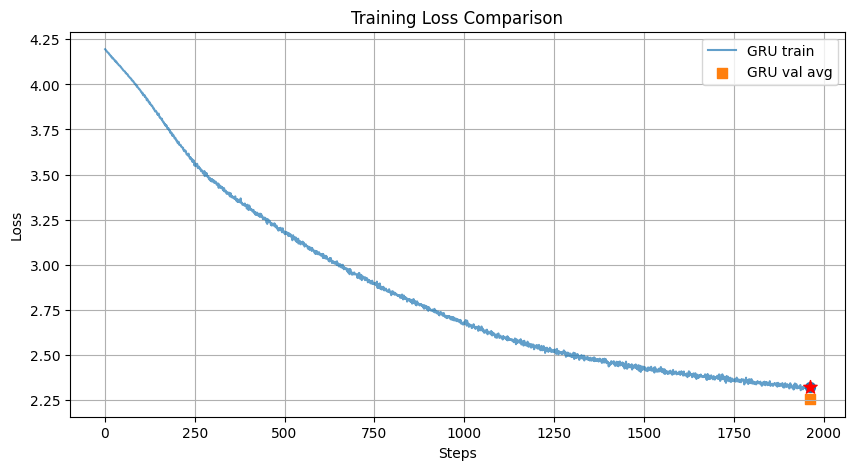

In [ ]:
plot_loss_comparisons()

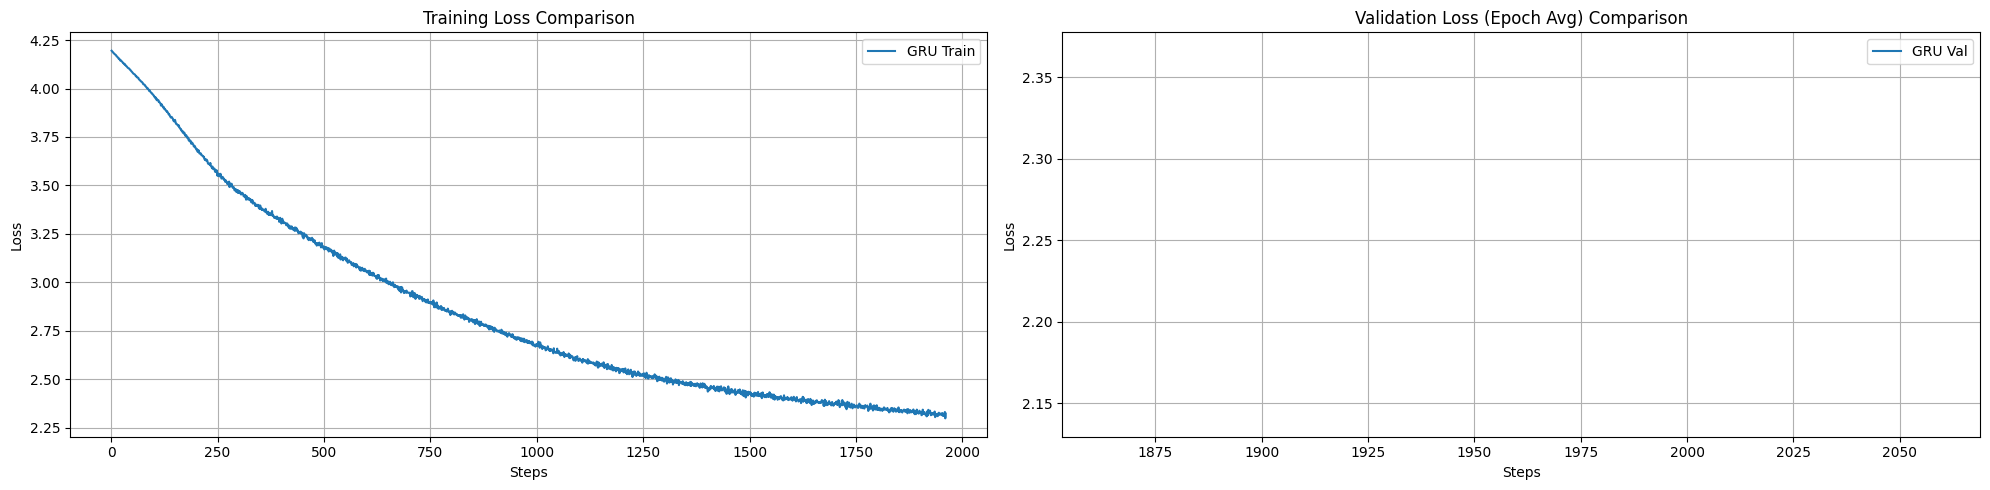

In [ ]:
plot_separate_train_val(loss_comparison_dict)

## Model 2: GPT-2(2019)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(dim, ffn_dim)
        self.fc2 = nn.Linear(ffn_dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_dim, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(dim)
        self.ffn = FeedForward(dim, ffn_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None, return_attn: bool = False):
        # Self-attention with residual connection
        x_norm = self.ln1(x)
        attn_out, attn_weights = self.attn(x_norm, x_norm, x_norm, attn_mask=mask)
        x = x + self.dropout(attn_out)
        # Feed-forward network with residual connection
        x = x + self.dropout(self.ffn(self.ln2(x)))
        if return_attn:
            return x, attn_weights
        return x

class ClassicTransformer(nn.Module):
    def __init__(self, vocab_size, max_seq_len, dim, num_layers, num_heads, ffn_dim, dropout):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Embedding(max_seq_len, dim)
        self.layers = nn.ModuleList([
            TransformerBlock(dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(dim)
        self.output = nn.Linear(dim, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.max_seq_len = max_seq_len
        
    def forward(self, x: torch.Tensor, return_attn: bool = False):
        # x: [B, L]
        B, L = x.shape
        pos_ids = torch.arange(0, L, device=x.device).unsqueeze(0).expand(B, L)
        # Sum token and positional embeddings
        h = self.token_embedding(x) + self.pos_embedding(pos_ids)
        h = self.dropout(h)
        
        # Causal mask (upper triangular with -inf)
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=x.device), diagonal=1)
        else:
            mask = None
        
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, mask)
            
        h = self.ln_f(h)
        logits = self.output(h)
        if return_attn:
            return logits, attn_maps
        return logits, None


In [ ]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [ ]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)

    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [ ]:
# Hyperparameters for Transformer
NUM_LAYERS = 2
NUM_HEADS = 4
FFN_DIM = 16
DROPOUT = 0.1

In [ ]:
classic = ClassicTransformer(vocab_size, SEQUENCE_LENGTH, EMBEDDING_DIM, NUM_LAYERS, NUM_HEADS, FFN_DIM, DROPOUT).to(device)
classic

ClassicTransformer(
  (token_embedding): Embedding(65, 32)
  (pos_embedding): Embedding(64, 32)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      )
      (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=32, out_features=16, bias=True)
        (fc2): Linear(in_features=16, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=32, out_features=65, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
from torchinfo import summary

# Describe the model
summary(classic.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
ClassicTransformer                       [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 32]             2,080
├─Embedding: 1-2                         [512, 64, 32]             2,048
├─Dropout: 1-3                           [512, 64, 32]             --
├─ModuleList: 1-4                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 32]             --
│    │    └─LayerNorm: 3-1               [512, 64, 32]             64
│    │    └─MultiheadAttention: 3-2      [512, 64, 32]             4,224
│    │    └─Dropout: 3-3                 [512, 64, 32]             --
│    │    └─LayerNorm: 3-4               [512, 64, 32]             64
│    │    └─FeedForward: 3-5             [512, 64, 32]             1,072
│    │    └─Dropout: 3-6                 [512, 64, 32]             --
│    └─TransformerBlock: 2-2             [512, 64, 32]             --
│  

Epoch 1/1, Train Loss: 2.7816, Val Loss: 2.8271, Epoch Time: 39.01s Average Vram Usage: 26.47MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrof, wis teshonunne;

Hmlangarhenist ha&gathad; tlanffiulak bou lonound k ar an od'fashowaliv f hkuy.ostir?e theeot
P j he t Wit thcokam sheeord h w's tsoomt fn seay,e'corouthe s

G ihdsiulelh, thoutt, peet me woc thetht pkereomoo kre bhmo S m wheteee senad
S s ores we sc b t

OCEUMmeiu hh VJThere n t!
anyond we,: mouddsuthe d pl wodarouoouromog emevetowheN f oEyul oor wd ssuved ad, is theeche wi mek v?isvifscclav l thithinroF hot m, d, oncfe m, ae:Whaen, w rsevonthe ord halinshefcathouhiy nuks m 


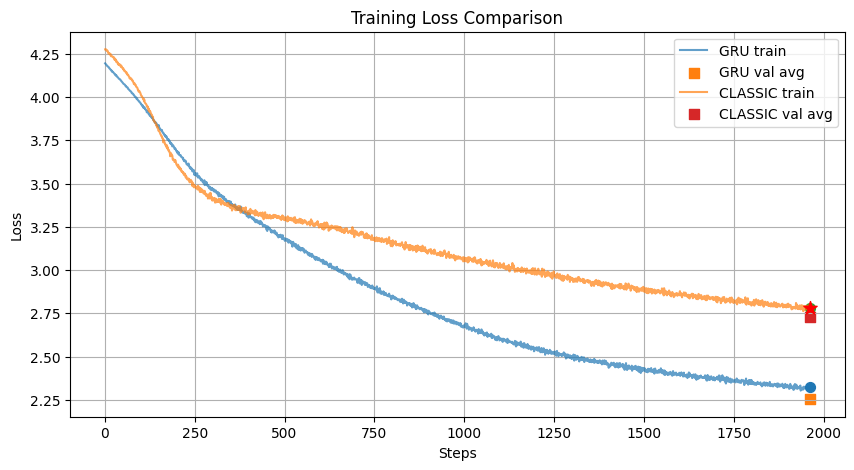

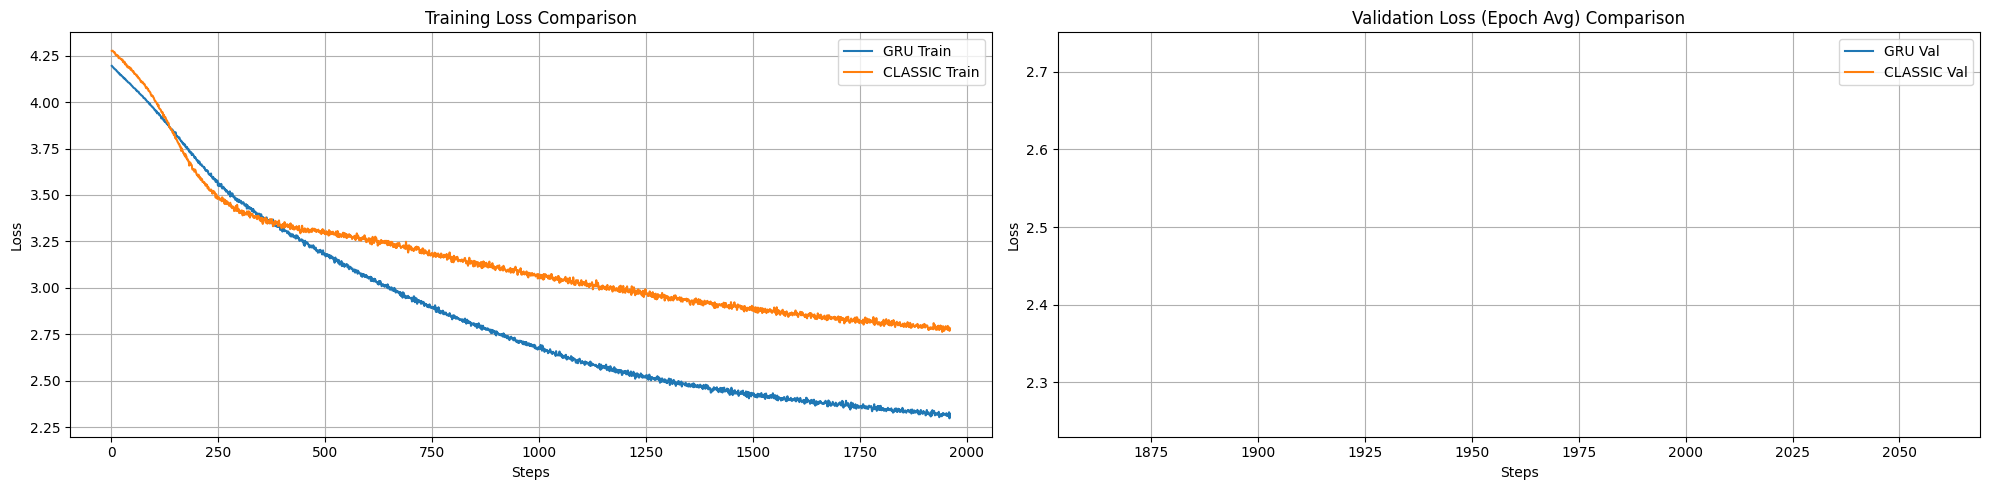

In [ ]:
train_and_test("CLASSIC", classic, start_text)

## Model 3: Modern Transformer(LLaMA - 2023)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    # FFN_DIM = HIDDEN_DIM
    FFN_DIM = 32
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS // 2
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 500000, ROPOMER: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 10000.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))
    
# GQA with KV cache and attention map output option
class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        # KV Cache
        self.cache_k = torch.zeros(batch, seq_len, n_kv_heads, self.head_dim, device=device)
        self.cache_v = torch.zeros(batch, seq_len, n_kv_heads, self.head_dim, device=device)
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # Update KV cache        
        self.cache_k[:B, offset:start_pos+L] = xk
        self.cache_v[:B, offset:start_pos+L] = xv
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [ ]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 32)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=32, out_features=32, bias=False)
        (wk): Linear(in_features=32, out_features=16, bias=False)
        (wv): Linear(in_features=32, out_features=16, bias=False)
        (wo): Linear(in_features=32, out_features=32, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=32, out_features=32, bias=False)
        (w2): Linear(in_features=32, out_features=32, bias=False)
        (w3): Linear(in_features=32, out_features=32, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=32, out_features=65, bias=False)
)

In [ ]:
from torchinfo import summary

# Describe the model
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 32]             2,080
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 32]             --
│    │    └─RMSNorm: 3-1                 [512, 64, 32]             32
│    │    └─SelfAttention: 3-2           [512, 64, 32]             3,080
│    │    └─Dropout: 3-3                 [512, 64, 32]             --
│    │    └─RMSNorm: 3-4                 [512, 64, 32]             32
│    │    └─FeedForward: 3-5             [512, 64, 32]             3,072
│    │    └─Dropout: 3-6                 [512, 64, 32]             --
│    └─TransformerBlock: 2-2             [512, 64, 32]             --
│    │    └─RMSNorm: 3-7                 [512, 64, 32]             32
│    │    └─SelfAttention: 3-8           [512, 64, 32]             3,080
│  

Epoch 1/1, Train Loss: 2.4743, Val Loss: 2.4538, Epoch Time: 46.47s Average Vram Usage: 132.76MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrour mit, dor ssto-
Per.
Oir lhele; st lilnd neMick wams amf det tre ;e by fow aat fof than lad Ad'singik thal:
Moft:
Seit

Mour atorngin acunas ing hachut sXDNe I monghy'e the sent,is
Lonstvrndm magnteee, the goWon noucouch tes
Thed anl noneis, sot fy befduve cs foris icoour sig menit gkncy shamet harsit yirrgh NanAnme sy theln pZasuryo Vfowe pes!
BAt rrours the you lat
EREme
TA sde owo: fere yalp cD neshe tTin porin.
th, ou no,h hilld I waorsdatll ce tof chang mi
arncinntond blond sous tau no oh


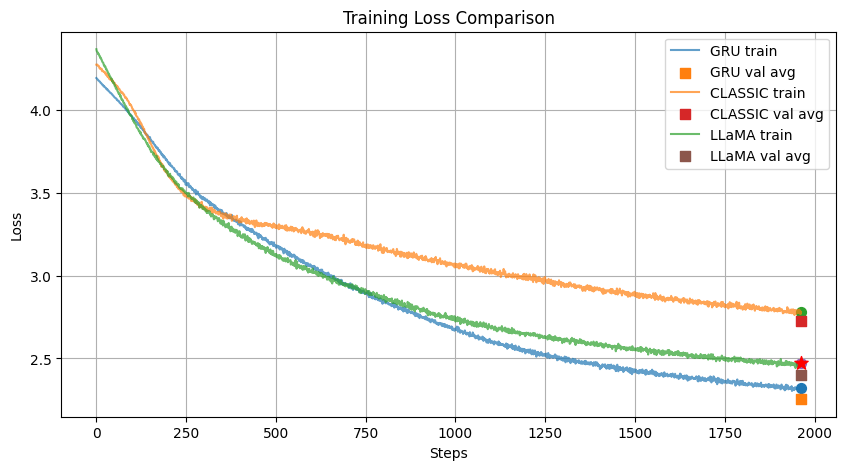

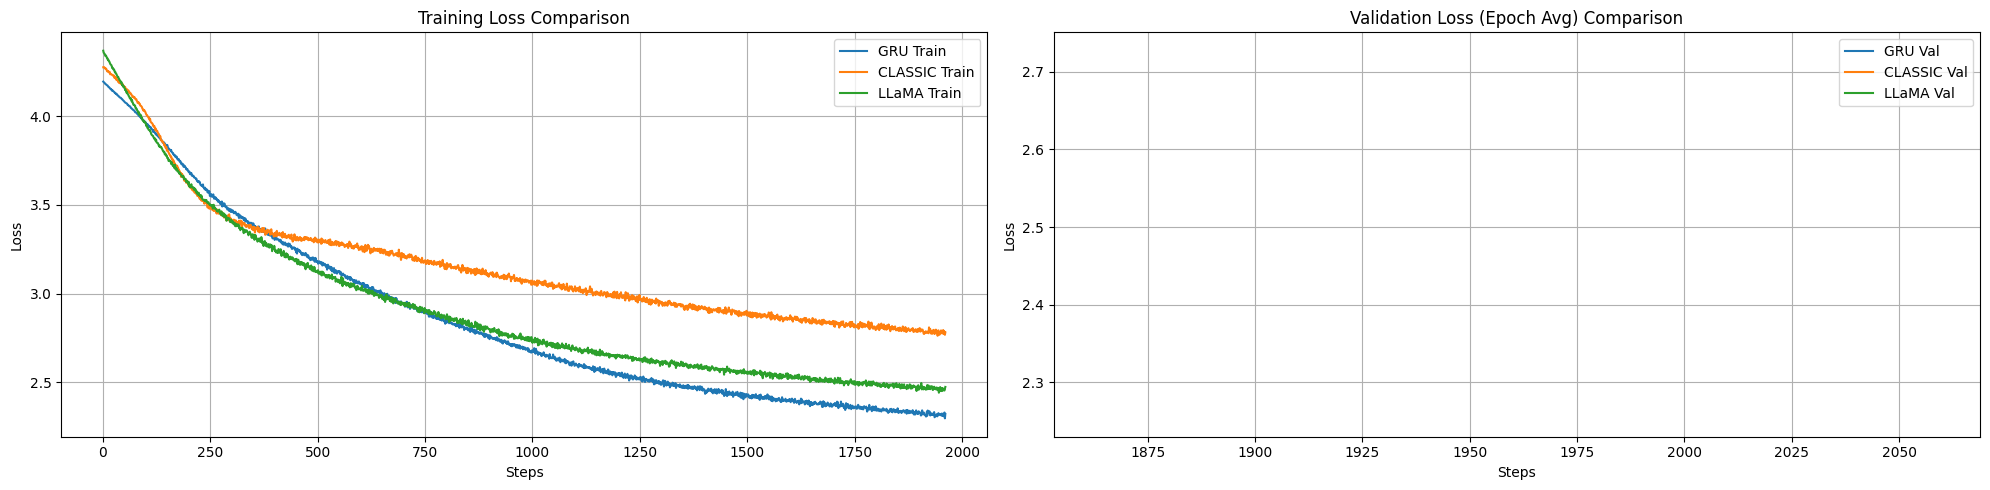

In [ ]:
train_and_test("LLaMA", llama, start_text)

## Model 4: Diff Transformer(2024)

In [ ]:
@dataclass
class ModelArgs:
    # DIM = EMBEDDING_DIM 
    DIM = 24
    # FFN_DIM = HIDDEN_DIM
    FFN_DIM = 32
    NUM_HEADS = NUM_HEADS // 2
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 500000, ROPOMER: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 10000.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    # x: [B, L, n_kv, d]
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

# FeedForward network.
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.w1 = nn.Linear(dim, ffn_dim, bias=False)
        self.w2 = nn.Linear(ffn_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, ffn_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

# Diffusion-based Self-Attention.
class DiffSelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device, depth=0):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep  # typically n_heads // n_kv_heads
        self.head_dim = dim // n_heads  # standard head dimension

        # For diff attention, project Q to 2*n_heads*head_dim,
        # and K, V to 2*n_kv_heads*head_dim.
        self.wq = nn.Linear(dim, 2 * n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        # Output projection expects input dim = 2*n_heads*head_dim.
        self.wo = nn.Linear(2 * n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout

        # KV Cache (for inference with caching)
        self.cache_k = torch.zeros(batch, 2 * n_heads, seq_len, self.head_dim, device=device)
        self.cache_v = torch.zeros(batch, n_heads, seq_len, 2 * self.head_dim, device=device)

        # Lambda parameter as in diff attention paper.
        self.lambda_init = 0.8 - 0.6 * math.exp(-0.3 * depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        
        # groupnorm
        self.norm = RMSNorm(2*self.head_dim)

    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos # same with start_pos
        
        # Project and reshape: 
        xq = self.wq(x).view(B, trg_len, 2 * self.n_heads_q, self.head_dim)   # [B, L, 2*heads, head_dim]
        xk = self.wk(x).view(B, src_len, 2 * self.n_kv_heads, self.head_dim)  # [B, L, 2*heads_kv, head_dim]
        xv = self.wv(x).view(B, src_len, self.n_kv_heads, 2 * self.head_dim)  # [B, L, heads_kv, 2*head_dim]
        
        # Apply rotary embeddings on queries and keys.
        xq = apply_rotary_emb(xq, device=x.device)
        xk = apply_rotary_emb(xk, device=x.device)
        
        # Grouped Query Attention:
        xq = xq.transpose(1, 2)                         # [B, 2*heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        
        # Update KV cache.
        self.cache_k[:B, :, offset:offset+L] = xk
        self.cache_v[:B, :, offset:offset+L] = xv
        
        # scaling
        scaling = 1 / math.sqrt(self.head_dim)
        xq *= scaling
        
        attn_weights = torch.matmul(xq, xk.transpose(-1, -2))
        
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
        
        attn_weights = torch.nan_to_num(attn_weights)
        attn_weights += mask
        attn_weights = F.softmax(attn_weights, dim=-1).type_as(attn_weights)
        attn_weights = attn_weights.view(B, self.n_heads_q, 2, trg_len, src_len)
        
        # Combine the two attention scores with lambda.
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(xq)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(xq)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        
        attn1 = attn_weights[:,:,0]
        attn2 = attn_weights[:,:,1]
        
        attn_weights = attn1 - lambda_full * attn2
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        
        # Compute attention output.
        attn = torch.matmul(attn_weights, xv)
        attn = self.norm(attn)
        attn = attn * (1-self.lambda_init)
        attn = attn.transpose(1, 2).contiguous().view(B, L, -1)
        attn_output = self.wo(attn)
        
        if return_attn:
            # Return four maps:
            # [첫 번째 맵(attn1), 두 번째 맵(attn2), 두 번째 맵에 람다를 곱한 결과, 최종 결과(attn_weights)]
            return attn_output, [attn1, attn2, lambda_full*attn2, attn_weights]
        else:
            return attn_output

# Transformer Block.
class TransformerBlock(nn.Module):
    def __init__(self, args, depth: int = 0):
        super().__init__()
        self.attn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.attention = DiffSelfAttention(
            n_heads=args.NUM_HEADS,
            n_kv_heads=args.NUM_KV_HEADS if args.NUM_KV_HEADS is not None else args.NUM_HEADS,
            n_rep=args.NUM_KV_HEAD_REP,
            dim=args.DIM,
            dropout=args.DROPOUT,
            batch=args.MAX_BATCH_SIZE,
            seq_len=args.MAX_SEQ_LEN,
            device=args.DEVICE,
            depth=depth
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attn_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attn_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class DiffTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args, depth=i) for i in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE

    def forward(self, x: torch.Tensor, start_pos: int = 0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, DIM]
        mask = None
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=self.device), diagonal=1)
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [ ]:
PARAMS = ModelArgs()
diff = DiffTransformer(PARAMS).to(device)
diff

DiffTransformer(
  (tok_embeddings): Embedding(65, 24)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attn_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (attention): DiffSelfAttention(
        (wq): Linear(in_features=24, out_features=48, bias=False)
        (wk): Linear(in_features=24, out_features=48, bias=False)
        (wv): Linear(in_features=24, out_features=48, bias=False)
        (wo): Linear(in_features=48, out_features=24, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=24, out_features=32, bias=False)
        (w2): Linear(in_features=32, out_features=24, bias=False)
        (w3): Linear(in_features=24, out_features=32, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=24, out_features=65, bias=False)
)

In [ ]:
from torchinfo import summary

# Describe the model
summary(diff.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DiffTransformer                          [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 24]             1,560
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 24]             --
│    │    └─RMSNorm: 3-1                 [512, 64, 24]             24
│    │    └─DiffSelfAttention: 3-2       [512, 64, 24]             4,680
│    │    └─Dropout: 3-3                 [512, 64, 24]             --
│    │    └─RMSNorm: 3-4                 [512, 64, 24]             24
│    │    └─FeedForward: 3-5             [512, 64, 24]             2,304
│    │    └─Dropout: 3-6                 [512, 64, 24]             --
│    └─TransformerBlock: 2-2             [512, 64, 24]             --
│    │    └─RMSNorm: 3-7                 [512, 64, 24]             24
│    │    └─DiffSelfAttention: 3-8       [512, 64, 24]             4,680
│  

Epoch 1/1, Train Loss: 2.5684, Val Loss: 2.5715, Epoch Time: 53.71s Average Vram Usage: 201.37MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrorons mad.
INAUSxong mhr st bul me!
e se to wouro Xoure dinth. cheTh:
Tt h,
Atod m;
NKAisip hinond mi'der din's:
Angndot ons.
F,llshe it:
I I':
INi;
D:

So'l me mithe nedcon,'fd
HyWerVO?
be lice nd t uden co hind n mE:'t
EKEN3ersepe tixe sog wond co:
Wangh awI oblgyoin silly knend its, mod chis yam thag thast,esas abe shhave-
Thaorne ilde lhourer mle therd thath lis cikThour c wt wMhy awis herfsu loxe Dey annd sag
b,fof Pel my f Sinve, atallchos cou.
I ;hestik mabed, maae s I danlQopn wame?
I did


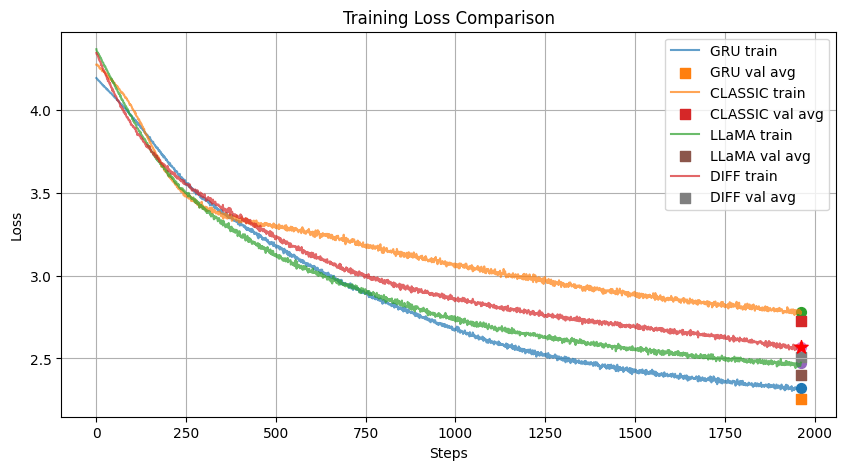

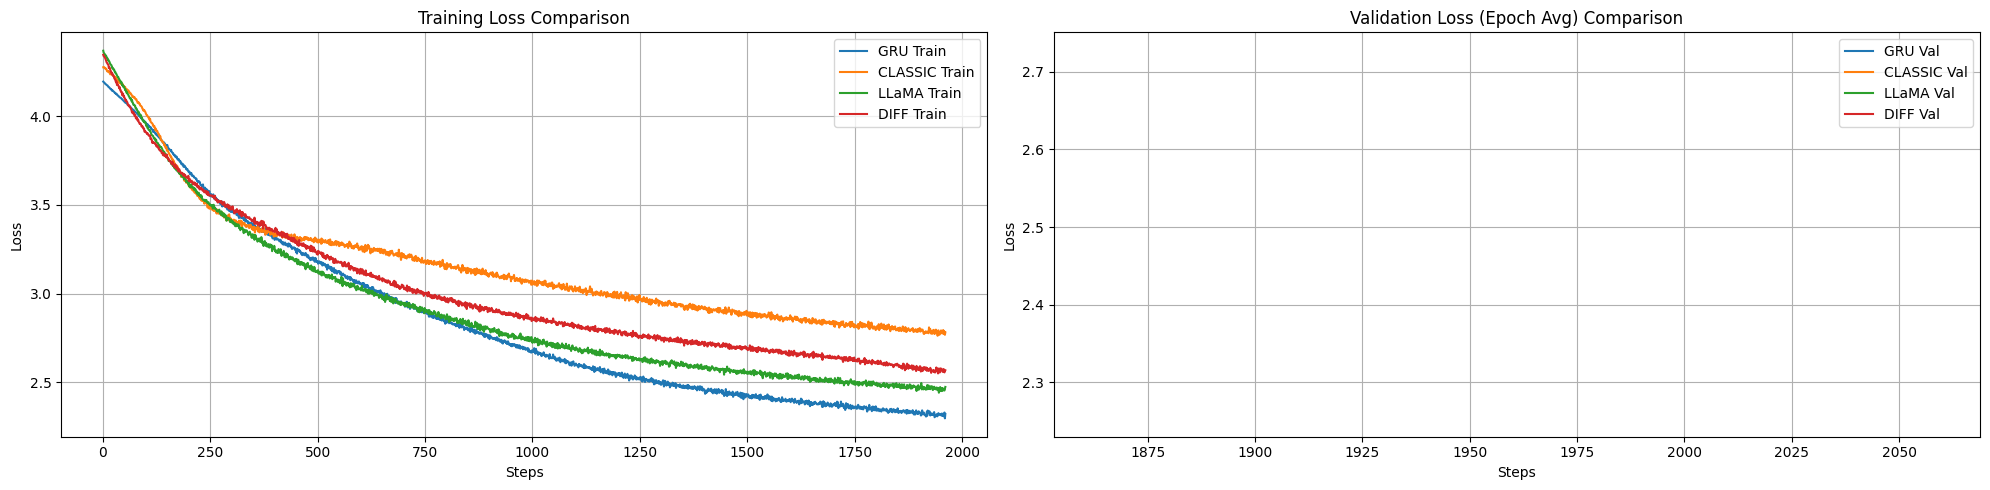

In [ ]:
train_and_test("DIFF", diff, start_text)

## Compare Attention Map

In [ ]:
import matplotlib.pyplot as plt
import torch

def compare_attention_maps(models_dict, dataloader, start_pos=0, layer=0, head=0):

    # Fetch a single batch from the dataloader.
    x, _ = next(iter(dataloader))
    device = 'cuda:0'
    x = x.to(device)
    
    attn_results = {}
    
    # For each model, perform a forward pass to obtain attention maps.
    for name, model in models_dict.items():
        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            # For classic model, assume its forward signature differs (doesn't need start_pos)
            if name == 'classic':
                _, attn_maps = model.forward(x, return_attn=True)
                attn = attn_maps[layer][head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'llama':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attn = attn_maps[layer][0, head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'diff':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attns = attn_maps[layer]         
                names = ['diff1', 'diff2', 'λ*diff2', 'diff1-λ*diff2']
                for name, attn in zip(names, attns):
                    attn_results[name] = attn[0, head].detach().cpu().numpy()
    
    # Plot attention maps side-by-side.
    n_models = len(attn_results)
    fig, axs = plt.subplots(1, n_models, figsize=(n_models * 4, 4))
    if n_models == 1:
        axs = [axs]
    for ax, (name, attn) in zip(axs, attn_results.items()):
        im = ax.imshow(attn, interpolation='nearest', cmap='viridis')
        ax.set_title(f"{name.upper()} \nLayer {layer+1}, Head {head+1}")
        ax.set_xlabel("Key Token Position")
        ax.set_ylabel("Query Token Position")
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

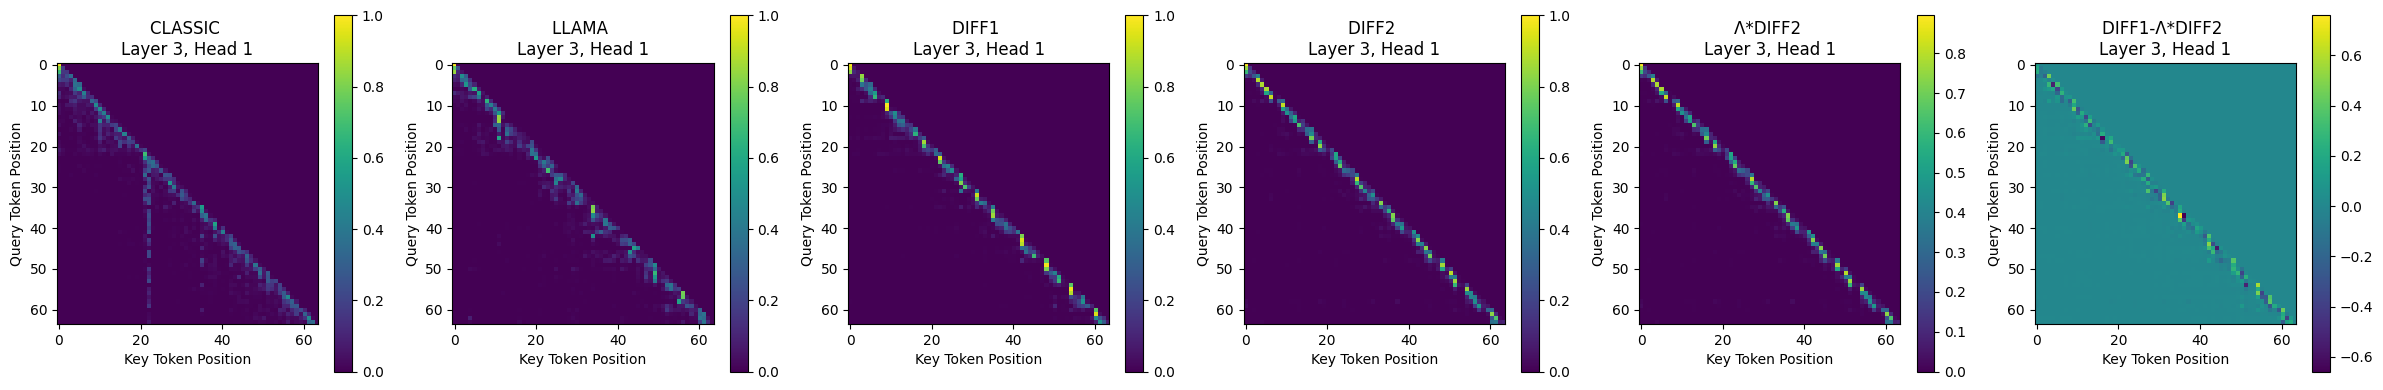

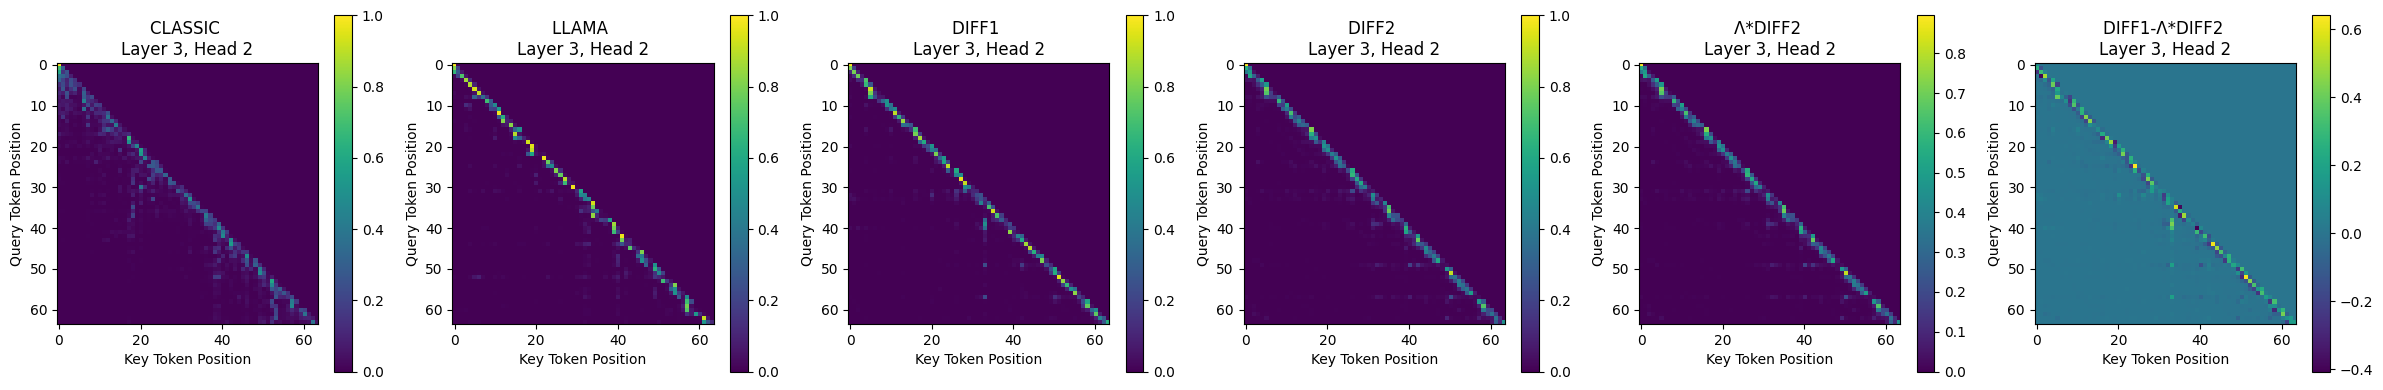

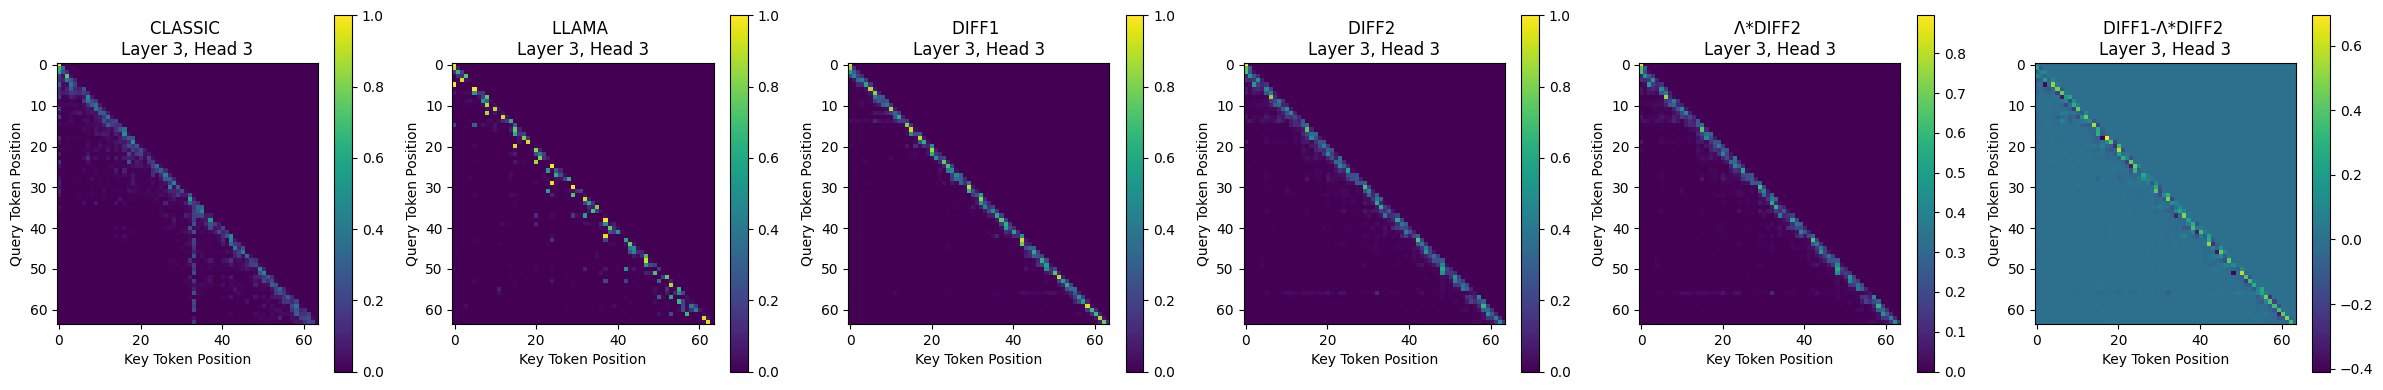

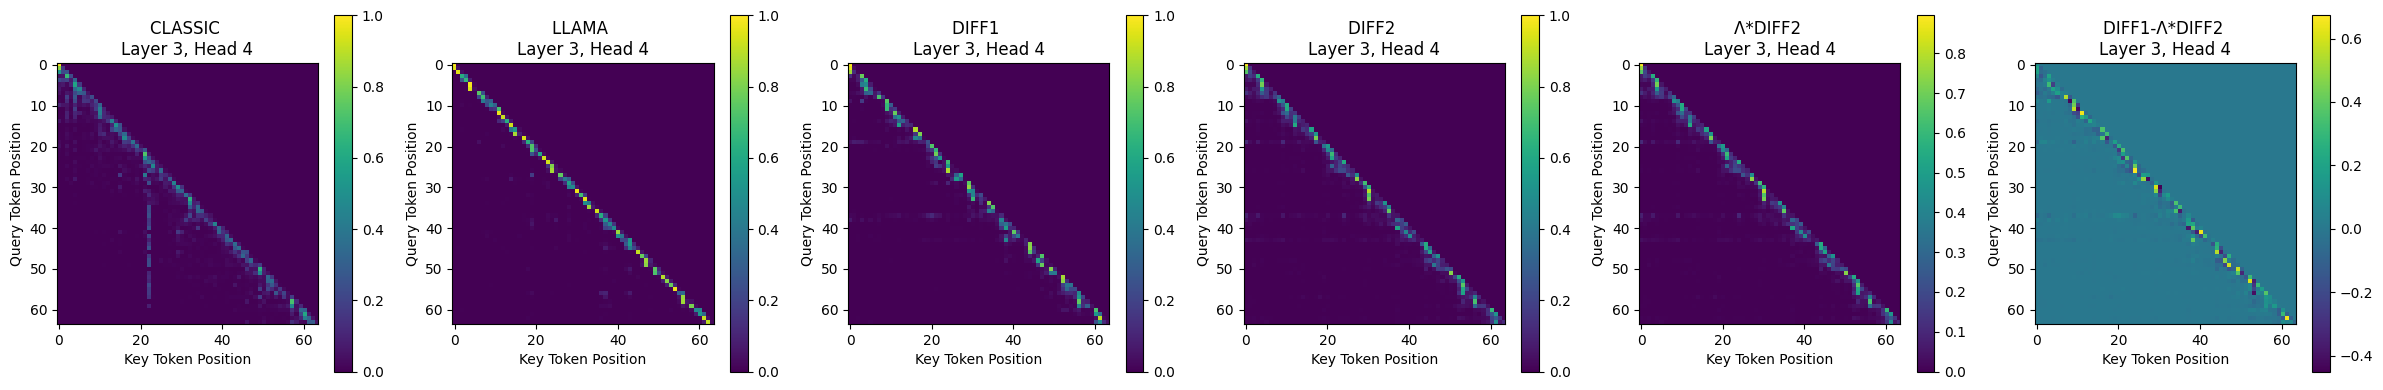

In [ ]:
models = {
    "classic": classic,
    "llama": llama,
    "diff": diff
}

for i in range(4):
    compare_attention_maps(models, train_loader, start_pos=0, layer=2, head=i)

In [ ]:
def compare_attention_maps_scaled(models_dict, dataloader, start_pos=0, layer=0, head=0):

    # Fetch a single batch from the dataloader.
    x, _ = next(iter(dataloader))
    device = 'cuda:0'
    x = x.to(device)
    
    attn_results = {}
    
    # For each model, perform a forward pass to obtain attention maps.
    for name, model in models_dict.items():
        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            # For classic model, assume its forward signature differs (doesn't need start_pos)
            if name == 'classic':
                _, attn_maps = model.forward(x, return_attn=True)
                attn = attn_maps[layer][head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'llama':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attn = attn_maps[layer][0, head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'diff':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attns = attn_maps[layer]         
                names = ['diff1', 'diff2', 'λ*diff2', 'diff1-λ*diff2']
                for name, attn in zip(names, attns):
                    attn = torch.clamp(attn[0, head], min=0.0)
                    attn_results[name] = attn.detach().cpu().numpy()
    
    # Plot attention maps side-by-side.
    n_models = len(attn_results)
    fig, axs = plt.subplots(1, n_models, figsize=(n_models * 4, 4))
    if n_models == 1:
        axs = [axs]
    for ax, (name, attn) in zip(axs, attn_results.items()):
        im = ax.imshow(attn, interpolation='nearest', cmap='viridis')
        ax.set_title(f"{name.upper()} \nLayer {layer+1}, Head {head+1}")
        ax.set_xlabel("Key Token Position")
        ax.set_ylabel("Query Token Position")
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

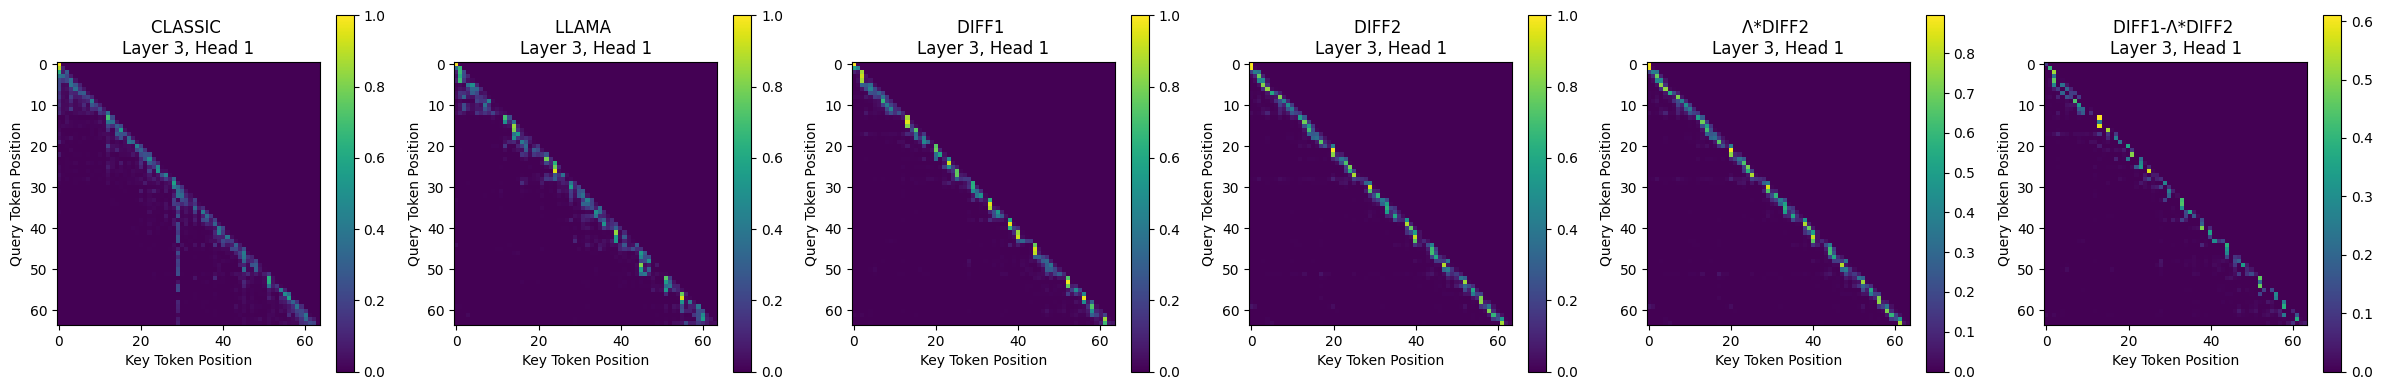

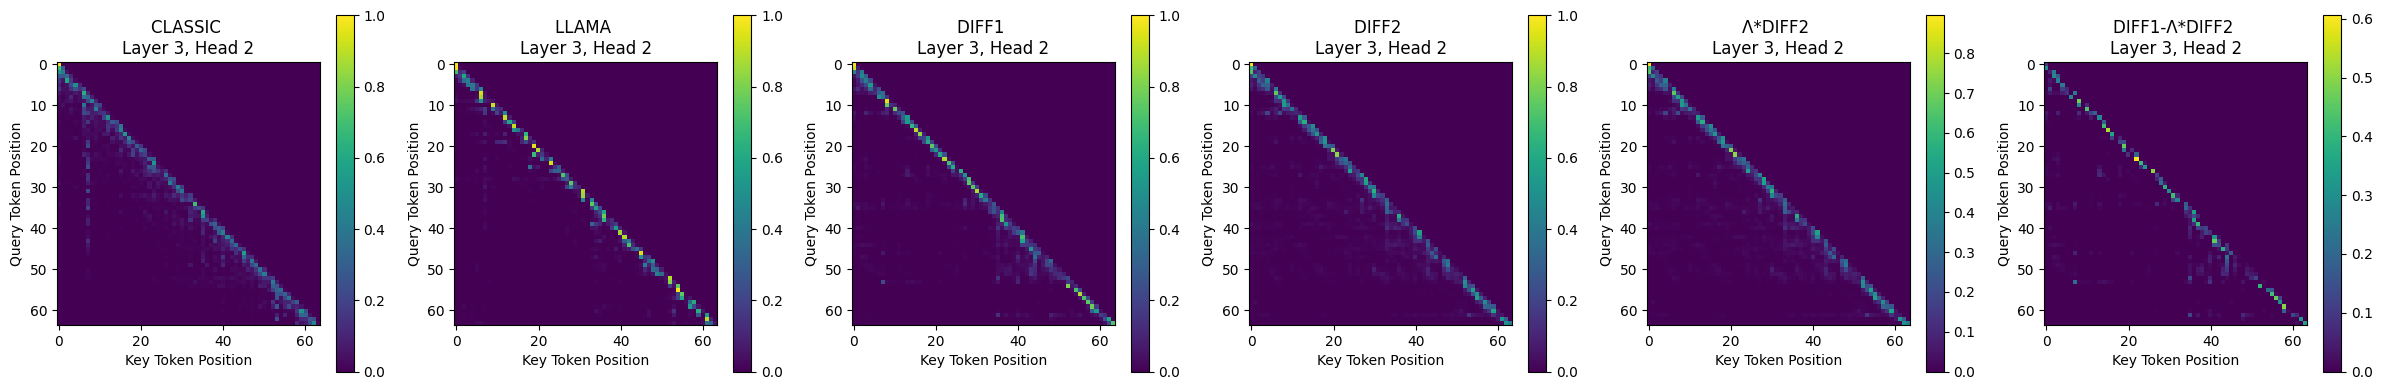

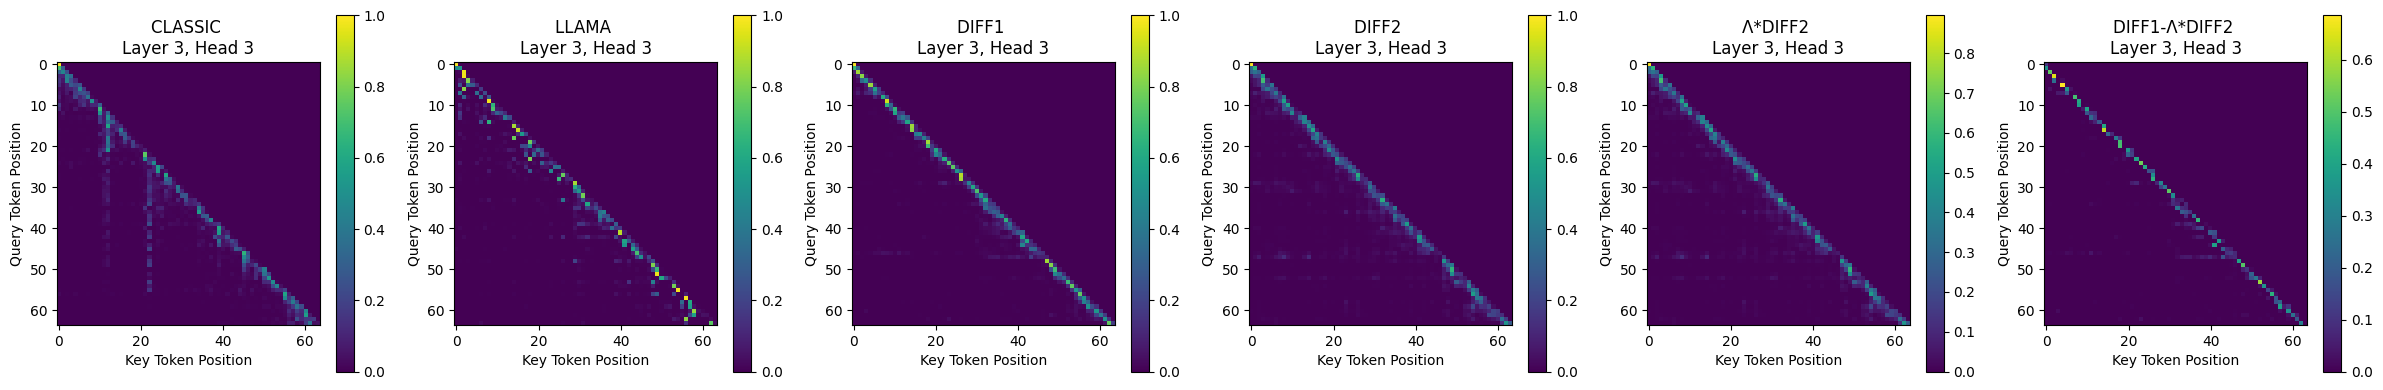

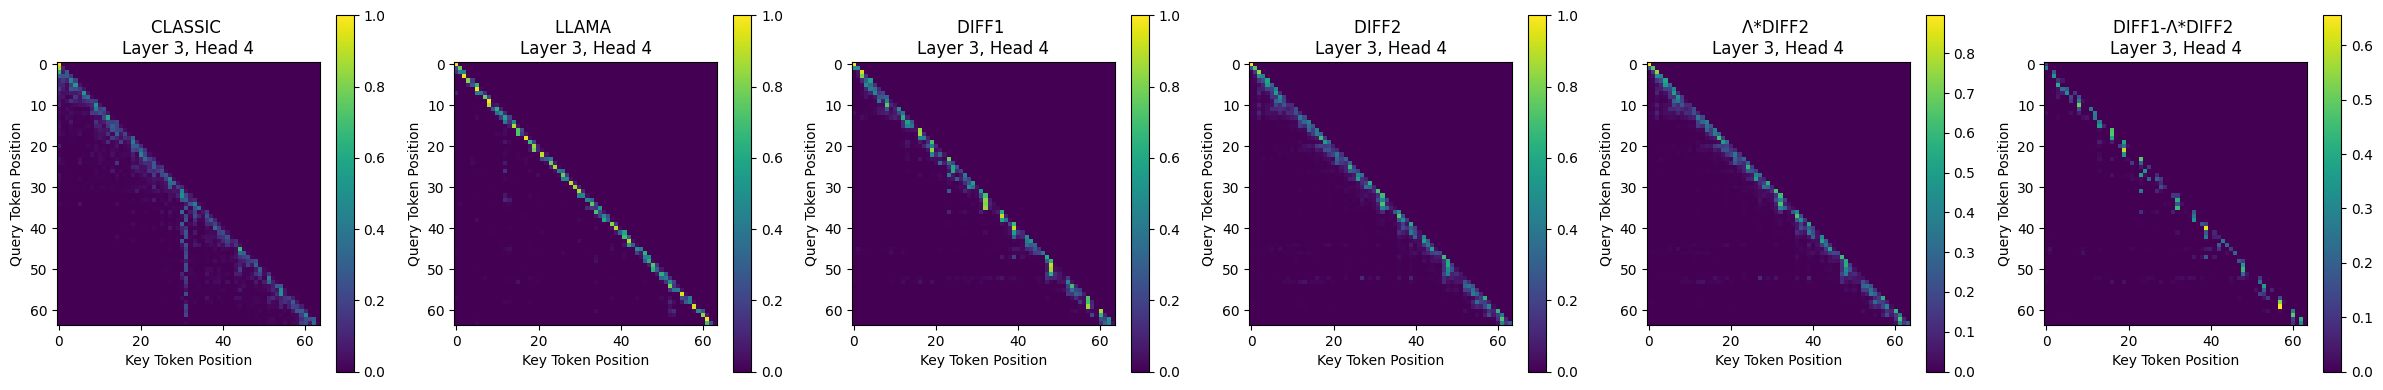

In [ ]:
models = {
    "classic": classic,
    "llama": llama,
    "diff": diff
}

for i in range(4):
    compare_attention_maps_scaled(models, train_loader, start_pos=0, layer=2, head=i)